# "Zillow Zingzestimate Project"

## Background

*Zillow is an online real estate database company founded in 2006 - Wikipedia.* “Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today). The Zillow Zestimate Zing Project will predict the error between Zestimate and the sales price of a home. 

- Project By `Ednalyn C. De Dios`
- Codeup Data Science
- ADA Cohort
- 25 March 2019

## Project Planning

### Goals

- Determine variables that drive log errors.
- Develop a linear regression model that will best predict the log errors.

### Deliverables

1. Report
1. Jupyter Notebook

### Data Dictionary & Details


***We will be using 2016 data.***

- logerror: log function of the error between Zestimate and sale price of a home.
- bathroomcnt:  Number of bathrooms in home including fractional bathrooms.
- bedroomcnt:  Number of bedrooms in home.
- calculatedfinishedsquarefeet:  Calculated total finished living area of the home.
- fullbathcnt:  Number of full bathrooms (sink, shower + bathtub, and toilet) present in home.
- garagecarcnt:  Total number of garages on the lot including an attached garage.
- roomcnt:  Total number of rooms in the principal residence.
- yearbuilt:  The Year the principal residence was built.
- taxvalueddollarcnt: The total tax assessed value of the parcel.
- taxamount: The total property tax assessed for that assessment year.

### Initial Thoughts, Ideas, Hypotheses

1. Location, location, location! Does location affect the log error?
1. To what extent does size matter?
1. How much do the number of bedroom and bathrooms play a role in driving the log error?
1. Depending on geography, do heating and air conditioning play a role?
1. What other variables drives the log error?


### Preparing the Environment

Libraries imported below for data wrangling, exploring, visualizing, and modeling will be used throughout the project.

In [1]:
# Wrangling
import pandas as pd
import math
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Modeling
import statsmodels.api as sm

from scipy.stats import pearsonr, ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.feature_selection import f_regression

from env import user, host, password, path

#### Utilities
*TODO: Functions to export in the `util.py` later.*

In [2]:
def summarize_df(df):
    print("Summary of Data\n")
    print("Rows & Columns:\n")
    print(df.shape)
    print("Variables:\n")
    var_names = df.columns.values
    print(var_names)
    print("\nColumn Info:\n")
    print(df.info())
    print("\nNumeric Summary Stats:\n")
    print(df.describe())
    print("\nTop 5 Values:\n")
    for var in var_names:
        print(var+":")
        print(df[var].value_counts().head())
        print('\n')
    print("\nMissing Values:\n")
    null_counts = df.isnull().sum()
    if len(null_counts[null_counts > 0]) == 0:
        print("No missing values")
    else:
        print(null_counts[null_counts > 0])
    print("\nFirst 5 rows:\n")
    print(df.head())
    print("\nEnd of Summary")

def validate_tts(X_train, y_train, X_test, y_test):
    if X_train.shape[0] == y_train.shape[0]:
        print("X & y train rows ARE equal")
    else:
        print("X & y train rows ARE NOT equal")


    if X_test.shape[0] == y_test.shape[0]:
        print("X & y test rows ARE equal")
    else:
        print("X & y test rows ARE NOT equal")

    if train.shape[1] == test.shape[1]:
        print("Number of columns in train & test ARE equal")
    else:
        print("Number of columns in train & test ARE NOT equal")

    train_split = train.shape[0] / (train.shape[0] + test.shape[0])
    test_split = test.shape[0] / (train.shape[0] + test.shape[0])

    print("Train Split: %.2f" % train_split)
    print("Test Split: %.2f" % test_split)

### Data Acquisition

- Acquire the data via csv files.
- Generate cohesive dataset with recommended columns.


In [3]:
# Acquire the data via csv
train_df = pd.read_csv(path+"train_2016_v2.csv", low_memory=False)
properties_df = pd.read_csv(path+"properties_2016.csv", low_memory=False)

# Generate a cohesive dataset
df = pd.merge(train_df, properties_df, on='parcelid', how='inner')
df = df[['logerror',
         'bathroomcnt',
         'bedroomcnt',
         'calculatedfinishedsquarefeet',
         'fullbathcnt',
         'garagecarcnt',
         'roomcnt',
         'yearbuilt',
         'taxvaluedollarcnt',
         'taxamount']]

Log errors were filtered organically after merging.

In [4]:
# Check for null values in the columns
print(df.isnull().sum())

# Check number of rows and columns after merging
print(df.shape)

logerror                            0
bathroomcnt                         0
bedroomcnt                          0
calculatedfinishedsquarefeet      661
fullbathcnt                      1182
garagecarcnt                    60338
roomcnt                             0
yearbuilt                         756
taxvaluedollarcnt                   1
taxamount                           6
dtype: int64
(90275, 10)


#### Discard unwanted columns.

In [5]:
# Remove these columns entirely due to high number of null and zero values
df = df.drop(['garagecarcnt', 'roomcnt'], axis=1)
print(df.sample(10))

       logerror  bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  \
23796    0.0080          2.0         3.0                        1240.0   
6243     0.0944          4.0         3.0                        3454.0   
55592    0.0507          3.0         3.0                        2144.0   
85233   -0.0555          3.0         2.0                        1289.0   
1612     0.0080          3.0         4.0                        2258.0   
4732     0.1544          2.0         3.0                        1278.0   
42405   -0.0284          2.0         2.0                        1409.0   
16689   -0.0111          2.0         3.0                        1248.0   
84443   -0.0121          3.0         4.0                        1930.0   
279      0.0421          2.0         3.0                        1269.0   

       fullbathcnt  yearbuilt  taxvaluedollarcnt  taxamount  
23796          2.0     1971.0            44670.0     486.00  
6243           4.0     1993.0          1295386.0   14201.62  

Summarize the data using predefined function.

In [6]:
# General dataset
summarize_df(df)

Summary of Data

Rows & Columns:

(90275, 8)
Variables:

['logerror' 'bathroomcnt' 'bedroomcnt' 'calculatedfinishedsquarefeet'
 'fullbathcnt' 'yearbuilt' 'taxvaluedollarcnt' 'taxamount']

Column Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 8 columns):
logerror                        90275 non-null float64
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
calculatedfinishedsquarefeet    89614 non-null float64
fullbathcnt                     89093 non-null float64
yearbuilt                       89519 non-null float64
taxvaluedollarcnt               90274 non-null float64
taxamount                       90269 non-null float64
dtypes: float64(8)
memory usage: 6.2 MB
None

Numeric Summary Stats:

           logerror   bathroomcnt    bedroomcnt  calculatedfinishedsquarefeet  \
count  90275.000000  90275.000000  90275.000000                  89614.000000   
mean       0.01145

### Data Preparation

Our goal is to leave this section with a dataset that is ready to be analyzed. 

In [7]:
# Discard rows where respective column contains null
df = df[df['calculatedfinishedsquarefeet'].notnull()]
df = df[df['fullbathcnt'].notnull()]
df = df[df['yearbuilt'].notnull()]
df = df[df['taxvaluedollarcnt'].notnull()]
df = df[df['taxamount'].notnull()]

# Check for null values
print(df.isnull().sum())
df.sample(10)

logerror                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fullbathcnt                     0
yearbuilt                       0
taxvaluedollarcnt               0
taxamount                       0
dtype: int64


,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
46586,-0.1199,2.0,4.0,3340.0,2.0,1955.0,183900.0,2260.35
56130,-0.0856,3.0,3.0,1576.0,3.0,1958.0,430335.0,5613.47
51599,-0.0450,2.0,3.0,1575.0,2.0,1960.0,491805.0,6115.95
87252,-0.9943,2.0,4.0,1944.0,2.0,1951.0,870918.0,10249.73
86893,-0.2627,2.0,2.0,992.0,2.0,1973.0,117052.0,1477.97
75369,0.2239,2.0,1.0,914.0,2.0,1947.0,45847.0,2248.48
43384,0.1553,2.0,3.0,1250.0,2.0,1980.0,242829.0,3449.61
59530,-0.0640,3.0,2.0,1618.0,3.0,1981.0,717226.0,8712.47
28956,0.0488,2.0,4.0,1911.0,2.0,1964.0,245236.0,3300.11
41785,0.0109,3.0,4.0,1932.0,3.0,1969.0,518989.0,6003.14


#### Create a variable, `colnames`, that is a list of the column names. 
We will likely reference this variable later.

In [8]:
colnames = ['logerror',
            'bathroomcnt',
            'bedroomcnt',
            'calculatedfinishedsquarefeet',
            'fullbathcnt',
            'yearbuilt',
            'taxvaluedollarcnt',
            'taxamount'
           ]
df.sample(10)

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
69130,0.0030,1.0,2.0,864.0,1.0,1990.0,321293.0,4230.18
59060,0.0431,1.0,2.0,1094.0,1.0,1950.0,810000.0,9633.56
29515,-0.9014,4.0,6.0,3386.0,4.0,1973.0,208201.0,2586.16
54946,-0.0171,2.0,4.0,1885.0,2.0,1966.0,628307.0,7338.50
43290,0.0050,2.5,3.0,2036.0,2.0,2001.0,733000.0,10247.06
73537,-0.0398,2.0,3.0,1375.0,2.0,1962.0,59496.0,1005.54
27355,0.1553,2.0,3.0,1478.0,2.0,1965.0,520000.0,5640.06
37755,0.0334,2.0,3.0,2578.0,2.0,1959.0,701920.0,8223.36
20337,0.0488,2.0,3.0,1242.0,2.0,1973.0,447721.0,4878.92
54616,0.0188,1.0,3.0,1123.0,1.0,1923.0,190704.0,2892.08


#### Identify the data types of each variable. Why? 
We need to make sure they are what makes sense for the data and the meaning of the data that lies in that variable. If it does not, make necessary changes.

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88998 entries, 0 to 90274
Data columns (total 8 columns):
logerror                        88998 non-null float64
bathroomcnt                     88998 non-null float64
bedroomcnt                      88998 non-null float64
calculatedfinishedsquarefeet    88998 non-null float64
fullbathcnt                     88998 non-null float64
yearbuilt                       88998 non-null float64
taxvaluedollarcnt               88998 non-null float64
taxamount                       88998 non-null float64
dtypes: float64(8)
memory usage: 6.1 MB
None


We still need to convert yearbuilt to integer and remove the trailing .0 as well.

In [10]:
# Convert from years to integer
df['yearbuilt'] = df['yearbuilt'].astype(int)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88998 entries, 0 to 90274
Data columns (total 8 columns):
logerror                        88998 non-null float64
bathroomcnt                     88998 non-null float64
bedroomcnt                      88998 non-null float64
calculatedfinishedsquarefeet    88998 non-null float64
fullbathcnt                     88998 non-null float64
yearbuilt                       88998 non-null int64
taxvaluedollarcnt               88998 non-null float64
taxamount                       88998 non-null float64
dtypes: float64(7), int64(1)
memory usage: 6.1 MB
None


In [11]:
df.sample(10)

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
76335,0.0266,3.0,2.0,1443.0,3.0,1985,632091.0,7761.06
51019,0.0060,2.0,4.0,1796.0,2.0,2005,152829.0,2692.73
53754,0.0070,2.0,3.0,1679.0,2.0,1964,430000.0,5745.91
51387,-0.0141,3.0,2.0,1271.0,3.0,1985,178036.0,2251.23
51805,-0.0758,2.0,2.0,976.0,2.0,1946,172712.0,2482.67
76077,0.0723,3.0,3.0,1920.0,3.0,2004,427000.0,8434.22
46928,0.1178,1.0,3.0,1363.0,1.0,1918,147461.0,1714.96
46347,-0.8187,2.0,4.0,2076.0,2.0,1977,315181.0,3296.84
43953,0.0129,2.0,3.0,1200.0,2.0,1957,53637.0,868.46
62393,0.0871,2.0,2.0,939.0,2.0,1987,311000.0,4477.72


#### Identify the columns that have missing values and the number of missing values in each column. 
Missing values are going to cause issues down the line so we will need to handle those appropriately. For each variable with missing values, if it makes sense to replace those missing with a 0, do so. For those where that doesn't make sense, decide if we should drop the entire observations (rows) that contain the missing values, or drop the entire variable (column) that contains the missing values.

In [12]:
# Check for null values
df.isnull().sum()

logerror                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fullbathcnt                     0
yearbuilt                       0
taxvaluedollarcnt               0
taxamount                       0
dtype: int64

#### Create a list of the independent variable names (aka attributes) and assign it to `x_vars` 
During exploration, we will likely use this list to refer to the attribute names.

In [13]:
x_vars = ['bathroomcnt',
          'bedroomcnt',
          'calculatedfinishedsquarefeet',
          'fullbathcnt',
          'yearbuilt',
          'taxvaluedollarcnt',
          'taxamount'
         ]

#### We need to clearly identify our dependent (target) variable. 
- `logerror` is our target variable, a continuous variable.

In [14]:
# Take the absolute value of log errors
df.logerror = df.logerror.abs()
df.logerror.sample(10)

6685     0.2062
51922    0.0325
25371    0.1178
25308    0.1080
22455    0.1924
13265    0.0111
64188    0.0315
88631    0.0383
30878    0.1613
4020     0.1823
Name: logerror, dtype: float64

#### View the distribution of the numeric variables
- We will plot a histogram and box plot of each variable to see the distribution, skewness, outliers, and unit scales. We will use this information in our decision of whether to normalize, standardize or neither.

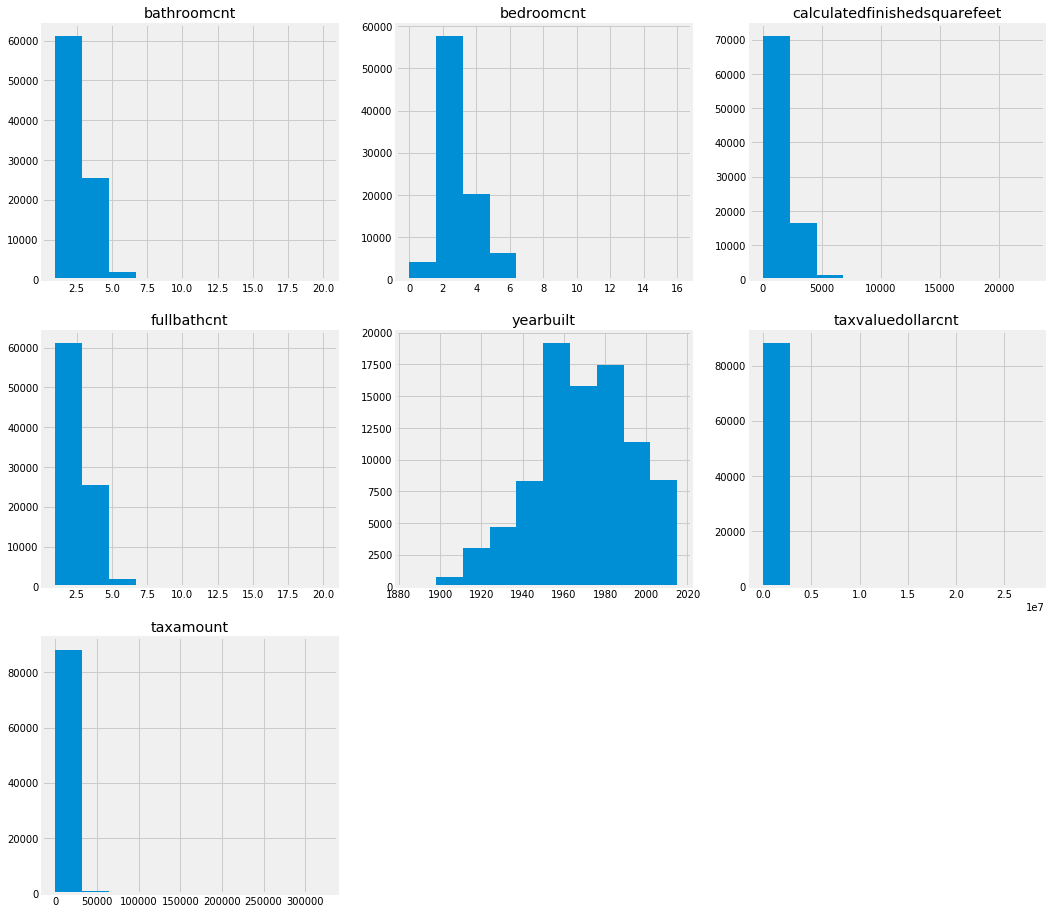

In [15]:
# Histogram
plt.figure(figsize=(16,16))
for i, col in enumerate(['bathroomcnt',
          'bedroomcnt',
          'calculatedfinishedsquarefeet',
          'fullbathcnt',
          'yearbuilt',
          'taxvaluedollarcnt',
          'taxamount'
         ]):
    plot_number = i + 1
    series = df[col]
    plt.subplot(3,3,plot_number)
    plt.title(col)
    series.hist()

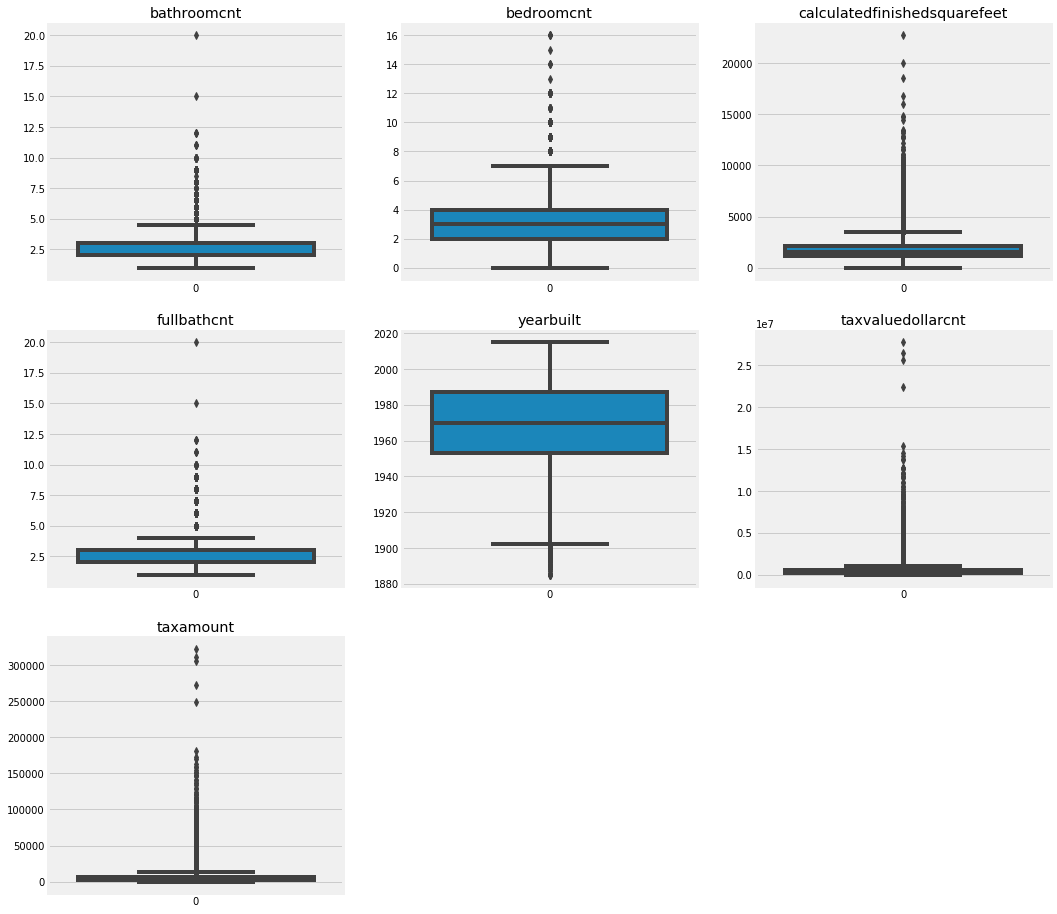

In [16]:
# Box plot
plt.figure(figsize=(16,16))
for i, col in enumerate(['bathroomcnt',
          'bedroomcnt',
          'calculatedfinishedsquarefeet',
          'fullbathcnt',
          'yearbuilt',
          'taxvaluedollarcnt',
          'taxamount'
         ]):
    plot_number = i + 1
    plt.subplot(3,3,plot_number)
    plt.title(col)
    sns.boxplot(data=df[col])

#### Discard unwated rows (observations).

In [17]:
# Remove outliers or nonsensical observations
df = df[df.bathroomcnt <= 12.5]
df = df[df.calculatedfinishedsquarefeet <= 17500]
df = df[df.fullbathcnt <= 12.5]
df = df[df.taxvaluedollarcnt <= 20000000.0]
df = df[df.taxamount <= 200000]
df.sample(10)

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
12438,0.0629,1.0,2.0,768.0,1.0,1949,240372.0,3075.53
58977,0.0408,1.0,3.0,1014.0,1.0,1949,246437.0,3168.43
68684,0.0222,1.0,3.0,1040.0,1.0,1928,186002.0,2084.34
35051,0.0284,2.0,2.0,956.0,2.0,1983,68337.0,1475.73
36467,0.0010,2.5,3.0,1659.0,2.0,2005,368859.0,9100.74
90268,0.0151,3.0,3.0,2438.0,3.0,1943,315288.0,5853.81
12766,0.0286,2.0,3.0,1245.0,2.0,1964,282000.0,3304.58
53001,0.0010,1.0,2.0,1392.0,1.0,1907,152259.0,1915.02
6648,0.0373,1.0,2.0,1098.0,1.0,1927,456000.0,10269.55
85919,0.0421,2.5,2.0,1533.0,2.0,2013,616523.0,9673.70


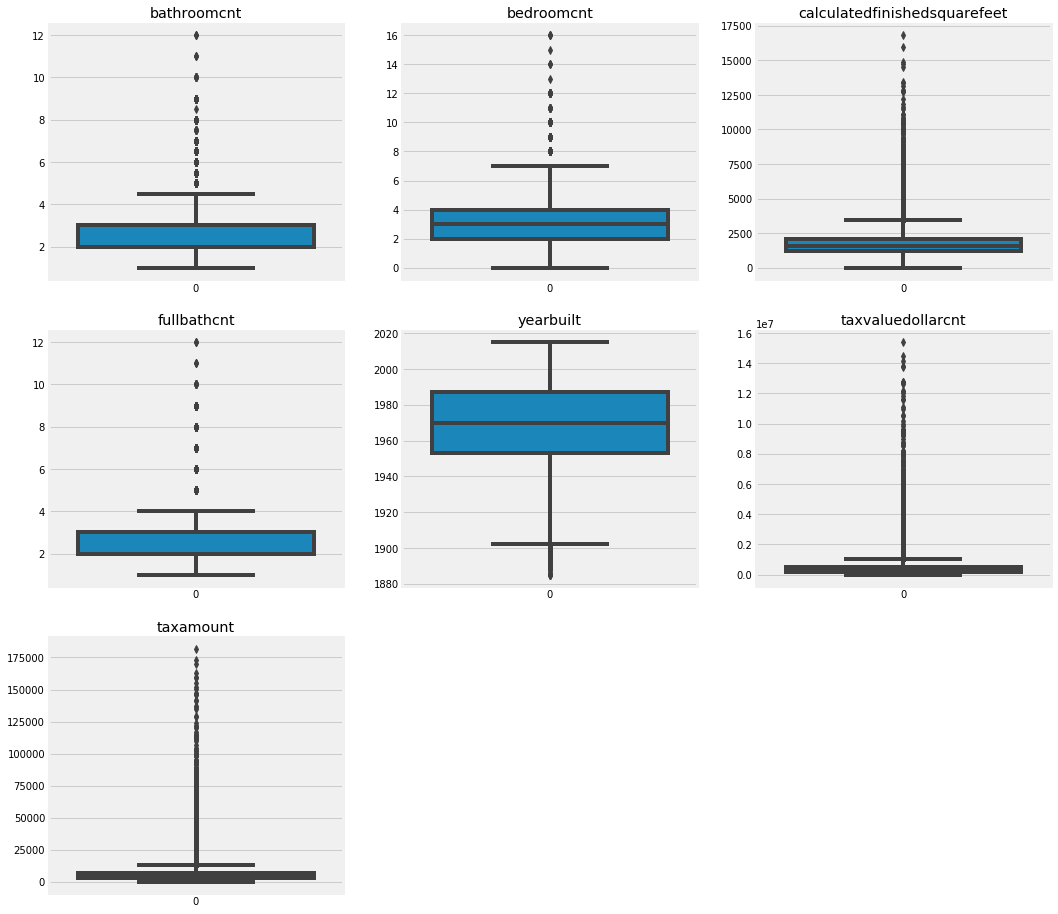

In [18]:
# Box plot
plt.figure(figsize=(16,16))
for i, col in enumerate(['bathroomcnt',
          'bedroomcnt',
          'calculatedfinishedsquarefeet',
          'fullbathcnt',
          'yearbuilt',
          'taxvaluedollarcnt',
          'taxamount'
         ]):
    plot_number = i + 1
    plt.subplot(3,3,plot_number)
    plt.title(col)
    sns.boxplot(data=df[col])

Save the snippet below for the min max normalization later.

In [19]:
# std_df = df.drop(colnames, axis=1)

# std_df['log_error'] = df.logerror

# #std_df['bathroom_count'] = (df.bathroomcnt - df.bathroomcnt.min()) / (df.bathroomcnt.max() - df.bathroomcnt.min())
# std_df['bathroom_count'] = df.bathroomcnt
# #std_df['bathroom_count'] = (df.bedroomcnt - df.bedroomcnt.min()) / (df.bedroomcnt.max() - df.bedroomcnt.min())
# std_df['bedroom_count'] = df.bedroomcnt
# #std_df['square_feet'] = (df.calculatedfinishedsquarefeet - df.calculatedfinishedsquarefeet.min()) / (df.calculatedfinishedsquarefeet.max() - df.calculatedfinishedsquarefeet.min())
# std_df['square_feet'] = df.calculatedfinishedsquarefeet
# #std_df['full_bath_count'] = (df.fullbathcnt - df.fullbathcnt.min()) / (df.fullbathcnt.max() - df.fullbathcnt.min())
# std_df['full_bath_count'] = df.fullbathcnt
# #std_df['year_built'] = (df.yearbuilt - df.yearbuilt.min()) / (df.yearbuilt.max() - df.yearbuilt.min())
# std_df['year_built'] = df.yearbuilt
# #std_df['tax_value_count'] = (df.taxvaluedollarcnt - df.taxvaluedollarcnt.min()) / (df.taxvaluedollarcnt.max() - df.taxvaluedollarcnt.min())
# std_df['tax_value_count'] = df.taxvaluedollarcnt
# #std_df['tax_amount'] = (df.taxamount - df.taxamount.min()) / (df.taxamount.max() - df.taxamount.min())
# std_df['tax_amount'] = df.taxamount



In [20]:
# Just to be sure...
df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88990 entries, 0 to 90274
Data columns (total 8 columns):
logerror                        88990 non-null float64
bathroomcnt                     88990 non-null float64
bedroomcnt                      88990 non-null float64
calculatedfinishedsquarefeet    88990 non-null float64
fullbathcnt                     88990 non-null float64
yearbuilt                       88990 non-null int64
taxvaluedollarcnt               88990 non-null float64
taxamount                       88990 non-null float64
dtypes: float64(7), int64(1)
memory usage: 8.6 MB


,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
71483,0.0010,2.0,3.0,2383.0,2.0,1935,879452.0,10763.99
71610,0.0573,3.0,4.0,2078.0,3.0,1978,785383.0,9521.41
85954,1.4770,2.5,4.0,1754.0,2.0,1965,428387.0,4908.02
18137,0.0305,5.0,4.0,3973.0,5.0,2013,1191676.0,14086.22
36329,0.1708,4.0,5.0,2602.0,4.0,1950,1930700.0,21381.78
61563,0.0263,1.0,2.0,796.0,1.0,1948,362000.0,4891.71
30709,0.0188,3.0,4.0,2014.0,3.0,1987,375975.0,3810.50
56092,0.0182,1.0,3.0,1586.0,1.0,1946,51155.0,847.24
83452,0.0325,2.0,2.0,985.0,2.0,1989,320100.0,4205.04
72302,0.0111,2.0,4.0,1404.0,2.0,1955,49517.0,907.15


### Data Exploration

Our goal is to address each of the questions we posed in our planning & brainstorming through visual or statistical analysis.

When we complete this step, we will have the findings from our analysis that will be used in our final report, the answers to our questions and our customer's questions that will reach the goal. 

*The idea and code below were inspired and adapted from Sudalai Raj Kumar (SRK) at https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize .*

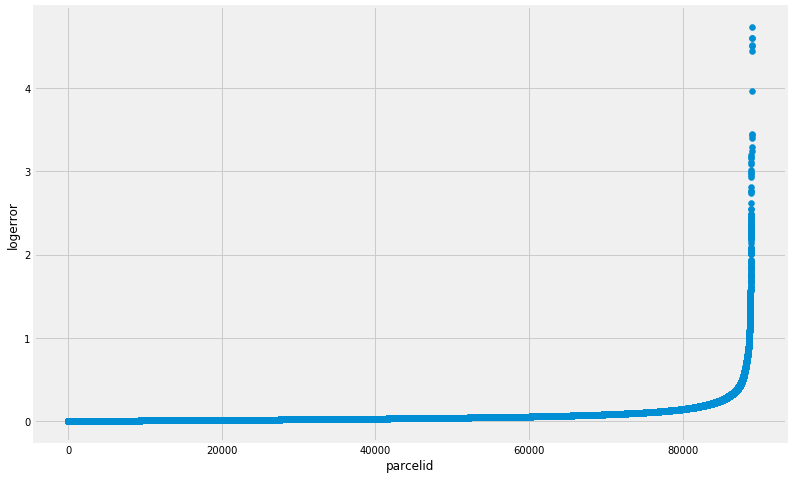

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


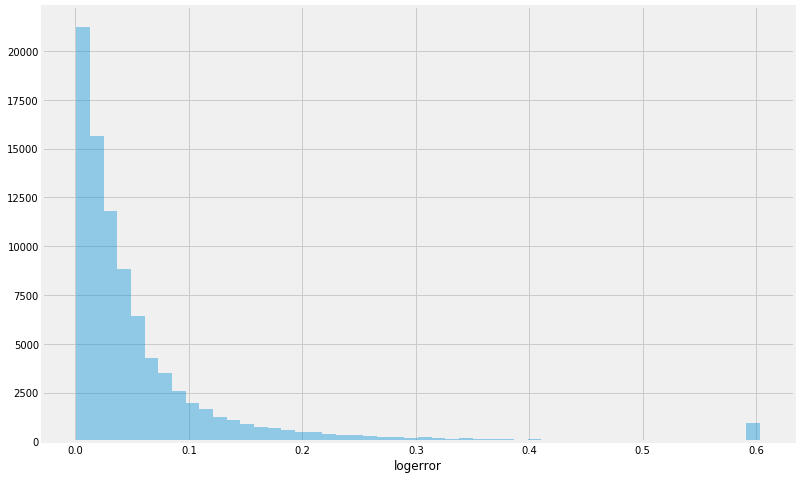

In [21]:
# Plot the log error
plt.figure(figsize=(12,8))
plt.scatter(range(df.shape[0]), np.sort(df.logerror.values))
plt.xlabel('parcelid')
plt.ylabel('logerror')
plt.show()

# Remove outliers
ulimit = np.percentile(df.logerror.values, 99)
llimit = np.percentile(df.logerror.values, 1)
df['logerror'].loc[df['logerror']>ulimit] = ulimit
df['logerror'].loc[df['logerror']<llimit] = llimit

# Plot the distribution
plt.figure(figsize=(12,8))
sns.distplot(df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror')
plt.show()

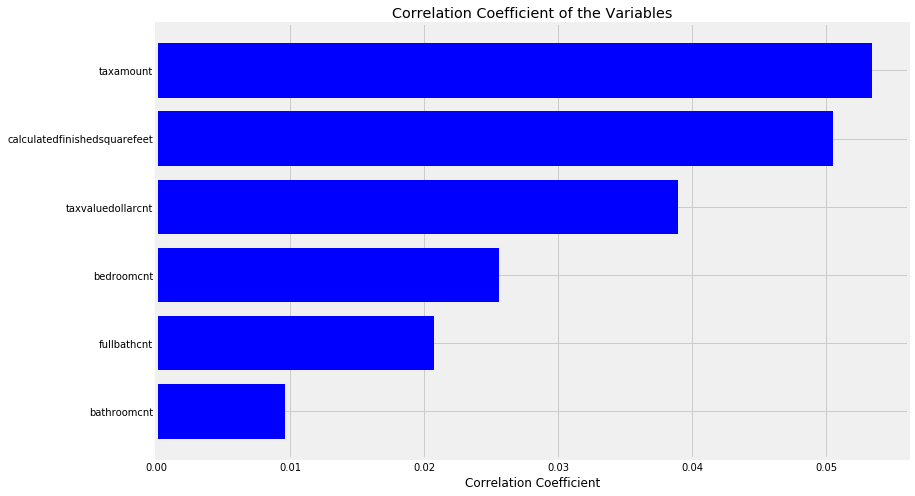

In [22]:
# Correlation coefficient of each of these variables
x_vars = [col for col in df.columns if col not in ['logerror'] if df[col].dtype=='float64']

labels = []
values = []
for col in x_vars:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df.logerror.values)[0,1])
correlation_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
correlation_df = correlation_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 1
fig, ax = plt.subplots(figsize=(12,8))
rects = ax.barh(ind, np.array(correlation_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(correlation_df.col_labels.values)
ax.set_xlabel("Correlation Coefficient")
ax.set_title("Correlation Coefficient of the Variables")
plt.show()

#### Split data into training and test datasets

In [23]:
# train_test_split
X = df.drop(['logerror'], axis=1)

print(X.head())

y = df[['logerror']]
print(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)

print()
print("Train columns:  %s" % list(train.columns))
print("Train dimensions (rows, columns):", train.shape)
print()

test = pd.concat([X_test, y_test], axis=1)

print("Test columns:  %s" % list(test.columns))
print("Test dimensions (rows, columns):", test.shape)
print()

validate_tts(X_train, y_train, X_test, y_test)

X.sample(10)

   bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  fullbathcnt  \
0          2.0         3.0                        1684.0          2.0   
1          3.5         4.0                        2263.0          3.0   
2          3.0         2.0                        2217.0          3.0   
3          2.0         2.0                         839.0          2.0   
4          2.5         4.0                        2283.0          2.0   

   yearbuilt  taxvaluedollarcnt  taxamount  
0       1959           360170.0    6735.88  
1       2014           585529.0   10153.02  
2       1940           119906.0   11484.48  
3       1987           244880.0    3048.74  
4       1981           434551.0    5488.96  
   logerror
0    0.0276
1    0.1684
2    0.0040
3    0.0218
4    0.0050

Train columns:  ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'yearbuilt', 'taxvaluedollarcnt', 'taxamount', 'logerror']
Train dimensions (rows, columns): (71192, 8)

Test columns:  ['bat

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
17789,3.0,4.0,1918.0,3.0,2014,820637.0,12515.92
28921,3.0,4.0,2201.0,3.0,1965,386159.0,4733.34
34335,2.0,2.0,910.0,2.0,1987,258000.0,3914.93
7677,2.0,4.0,1850.0,2.0,1988,339373.0,5163.86
82004,1.0,1.0,800.0,1.0,1921,636530.0,7782.95
54816,1.0,2.0,832.0,1.0,1984,392000.0,4116.24
54405,3.0,7.0,3130.0,3.0,2002,365000.0,6040.91
7319,1.0,3.0,626.0,1.0,1923,537559.0,5880.97
83048,3.0,3.0,2503.0,3.0,1979,869340.0,11416.91
83109,1.5,3.0,1363.0,1.0,1973,225672.0,2641.22


#### MIN-MAX NORMALIZATION

In [24]:
std_y_train = y_train.drop('logerror', axis=1)
std_y_train['log_error'] = y_train.logerror

std_X_train = X_train.drop(x_vars, axis=1)
std_X_train['bathroom_count'] = (X_train.bathroomcnt - X_train.bathroomcnt.min()) / (X_train.bathroomcnt.max() - X_train.bathroomcnt.min())
std_X_train['bedroom_count'] = (X_train.bedroomcnt - X_train.bedroomcnt.min()) / (X_train.bedroomcnt.max() - X_train.bedroomcnt.min())
std_X_train['square_feet'] = (X_train.calculatedfinishedsquarefeet - X_train.calculatedfinishedsquarefeet.min()) / (X_train.calculatedfinishedsquarefeet.max() - X_train.calculatedfinishedsquarefeet.min())
std_X_train['full_bath_count'] = (X_train.fullbathcnt - X_train.fullbathcnt.min()) / (X_train.fullbathcnt.max() - X_train.fullbathcnt.min())
std_X_train['year_built'] = (X_train.yearbuilt - X_train.yearbuilt.min()) / (X_train.yearbuilt.max() - X_train.yearbuilt.min())
std_X_train['tax_value_count'] = (X_train.taxvaluedollarcnt - X_train.taxvaluedollarcnt.min()) / (X_train.taxvaluedollarcnt.max() - X_train.taxvaluedollarcnt.min())
std_X_train['tax_amount'] = (X_train.taxamount - X_train.taxamount.min()) / (X_train.taxamount.max() - X_train.taxamount.min())

std_y_test = y_test.drop('logerror', axis=1)
std_y_test['log_error'] = y_test.logerror

std_X_test = X_test.drop(x_vars, axis=1)
std_X_test['bathroom_count'] = (X_test.bathroomcnt - X_train.bathroomcnt.min()) / (X_train.bathroomcnt.max() - X_train.bathroomcnt.min())
std_X_test['bedroom_count'] = (X_test.bedroomcnt - X_train.bedroomcnt.min()) / (X_train.bedroomcnt.max() - X_train.bedroomcnt.min())
std_X_test['square_feet'] = (X_test.calculatedfinishedsquarefeet - X_train.calculatedfinishedsquarefeet.min()) / (X_train.calculatedfinishedsquarefeet.max() - X_train.calculatedfinishedsquarefeet.min())
std_X_test['full_bath_count'] = (X_test.fullbathcnt - X_train.fullbathcnt.min()) / (X_train.fullbathcnt.max() - X_train.fullbathcnt.min())
std_X_test['year_built'] = (X_test.yearbuilt - X_train.yearbuilt.min()) / (X_train.yearbuilt.max() - X_train.yearbuilt.min())
std_X_test['tax_value_count'] = (X_test.taxvaluedollarcnt - X_train.taxvaluedollarcnt.min()) / (X_train.taxvaluedollarcnt.max() - X_train.taxvaluedollarcnt.min())
std_X_test['tax_amount'] = (X_test.taxamount - X_train.taxamount.min()) / (X_train.taxamount.max() - X_train.taxamount.min())


In [25]:
std_train = pd.concat([std_X_train, std_y_train], axis=1)

print()
print("std_train columns:  %s" % list(std_train.columns))
print("std_train dimensions (rows, columns):", std_train.shape)
print()

std_test = pd.concat([std_X_test, std_y_test], axis=1)

print("std_test columns:  %s" % list(std_test.columns))
print("std_test dimensions (rows, columns):", std_test.shape)
print()



std_train columns:  ['yearbuilt', 'bathroom_count', 'bedroom_count', 'square_feet', 'full_bath_count', 'year_built', 'tax_value_count', 'tax_amount', 'log_error']
std_train dimensions (rows, columns): (71192, 9)

std_test columns:  ['yearbuilt', 'bathroom_count', 'bedroom_count', 'square_feet', 'full_bath_count', 'year_built', 'tax_value_count', 'tax_amount', 'log_error']
std_test dimensions (rows, columns): (17798, 9)



#### Create a jointplot for each independent variable with the dependent variable. 
- UNnormalized version

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


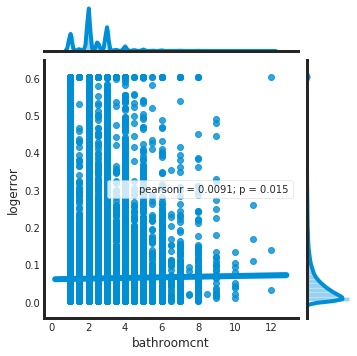

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


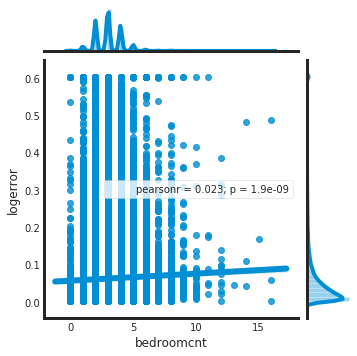

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


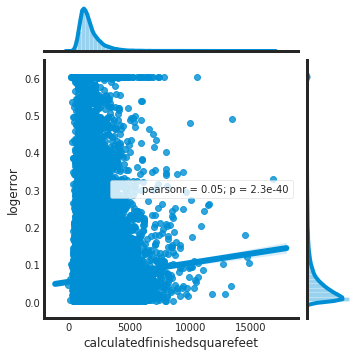

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


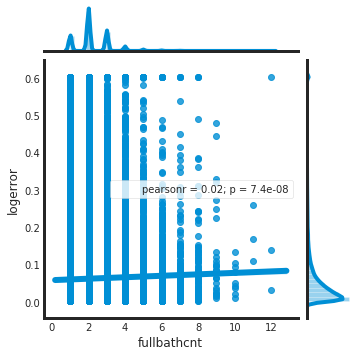

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


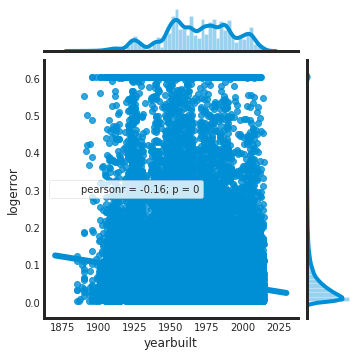

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


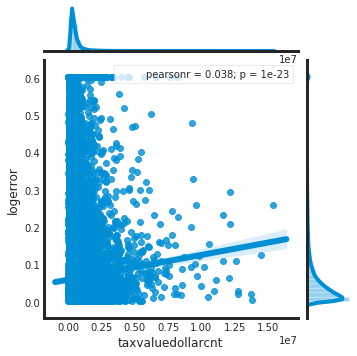

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


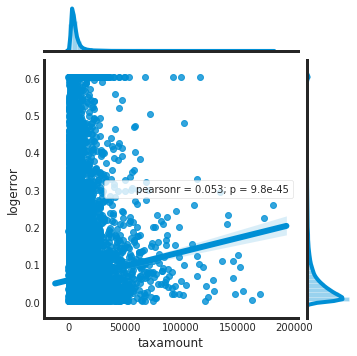

In [26]:
with sns.axes_style('white'):
    j = sns.jointplot('bathroomcnt', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('bedroomcnt', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('calculatedfinishedsquarefeet', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('fullbathcnt', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('yearbuilt', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('taxvaluedollarcnt', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('taxamount', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

#### Create a jointplot for each independent variable with the dependent variable. 
- normalized version

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


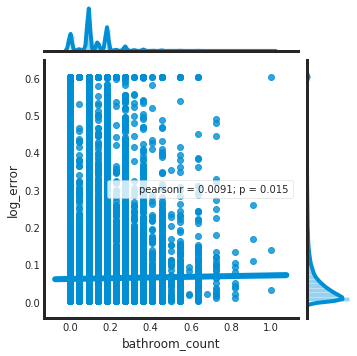

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


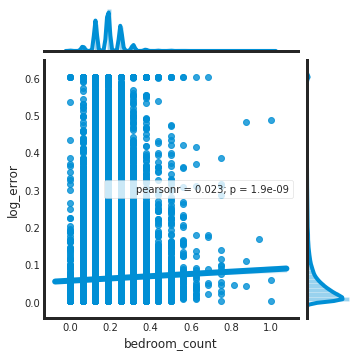

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


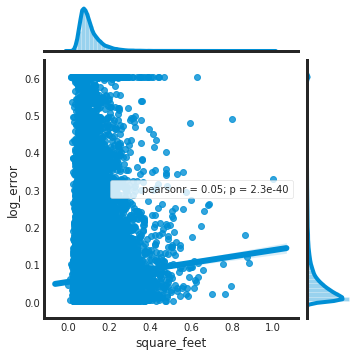

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


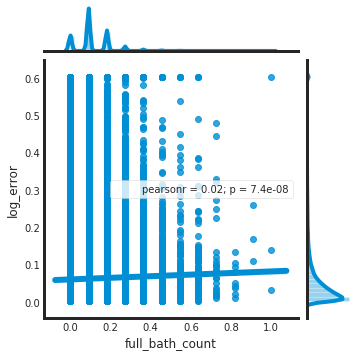

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


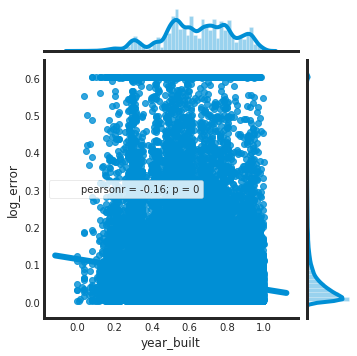

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


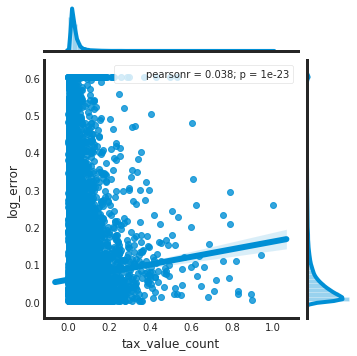

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


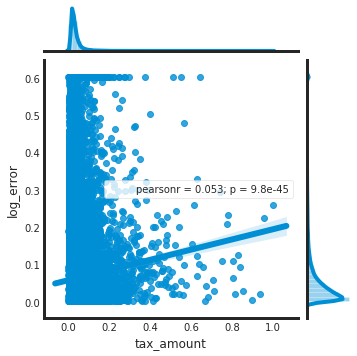

In [27]:
with sns.axes_style('white'):
    j = sns.jointplot('bathroom_count', "log_error", data=std_train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('bedroom_count', "log_error", data=std_train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('square_feet', "log_error", data=std_train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('full_bath_count', "log_error", data=std_train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('year_built', "log_error", data=std_train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('tax_value_count', "log_error", data=std_train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('tax_amount', "log_error", data=std_train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

#### Create a feature plot using seaborn's PairGrid() of the interaction between each variable (dependent + independent). 
- UNnormalized version

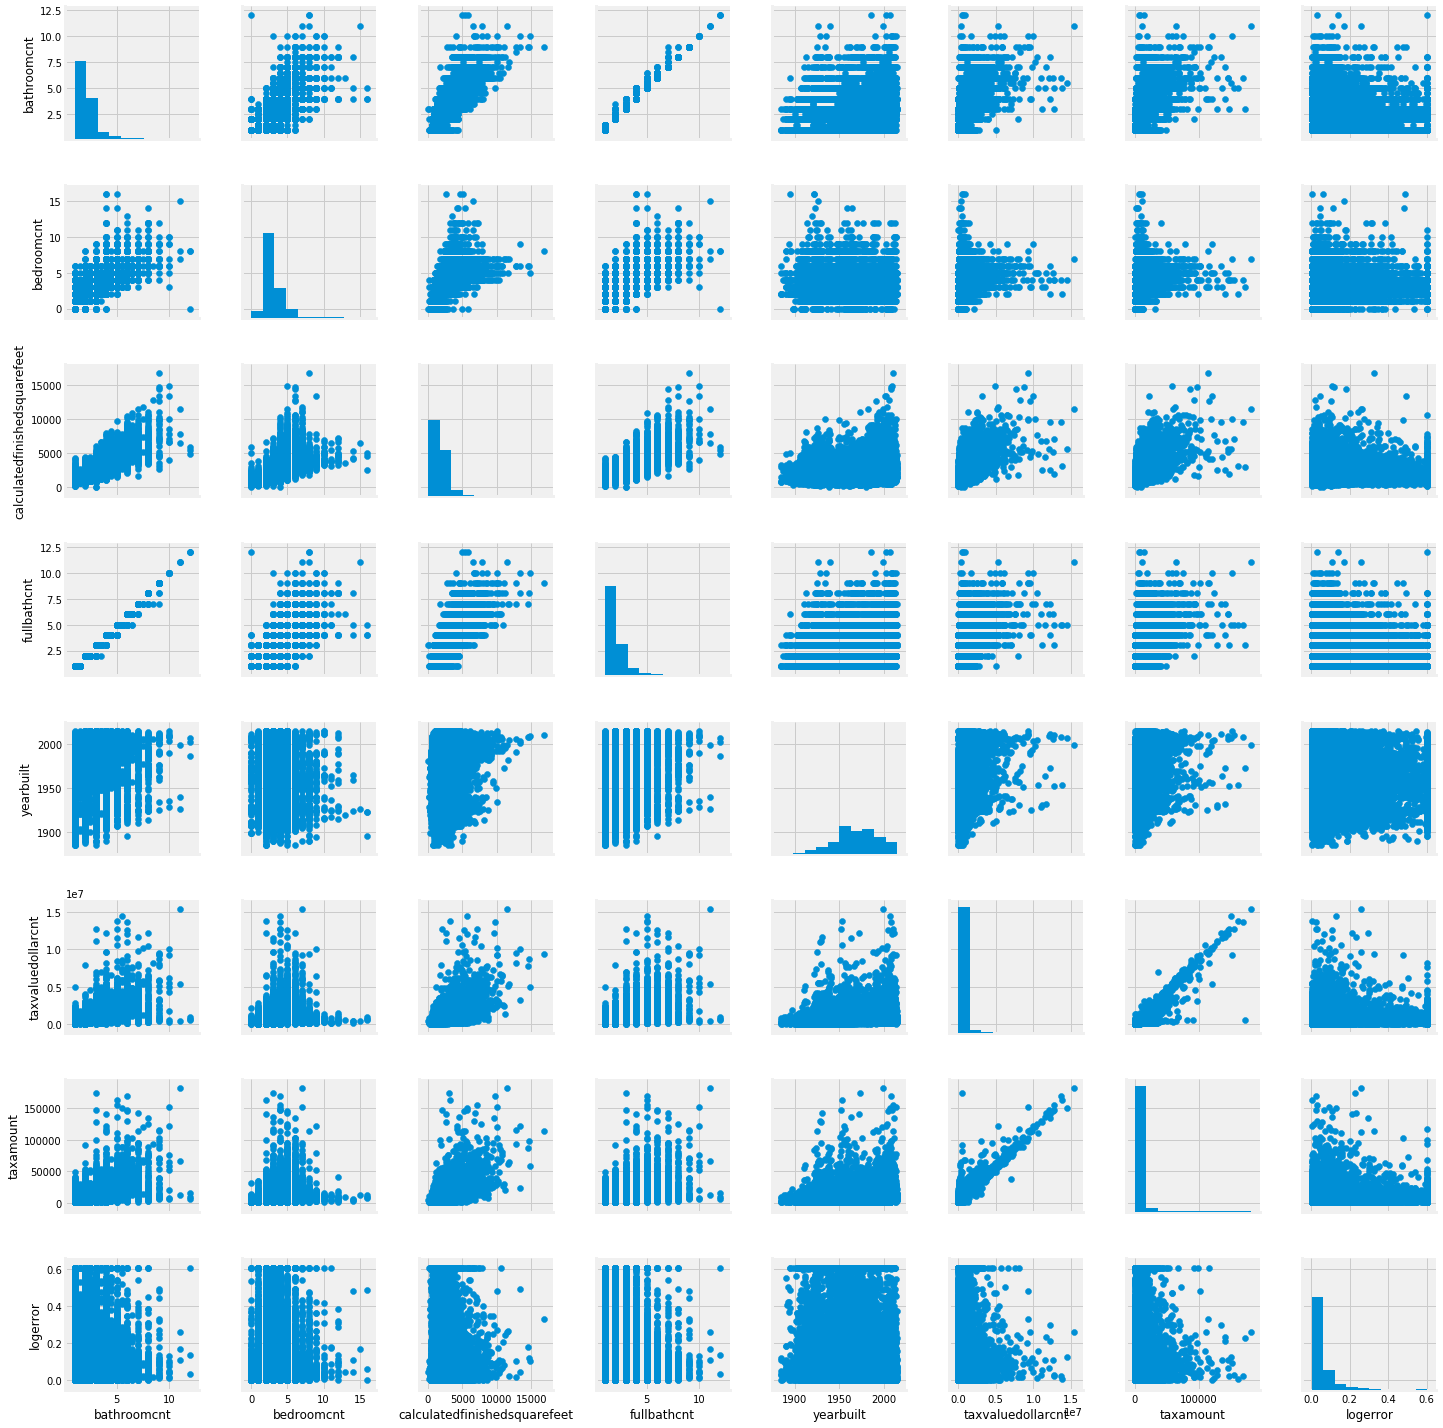

In [28]:
g = sns.PairGrid(train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

#### Create a feature plot using seaborn's PairGrid() of the interaction between each variable (dependent + independent). 
- normalized version

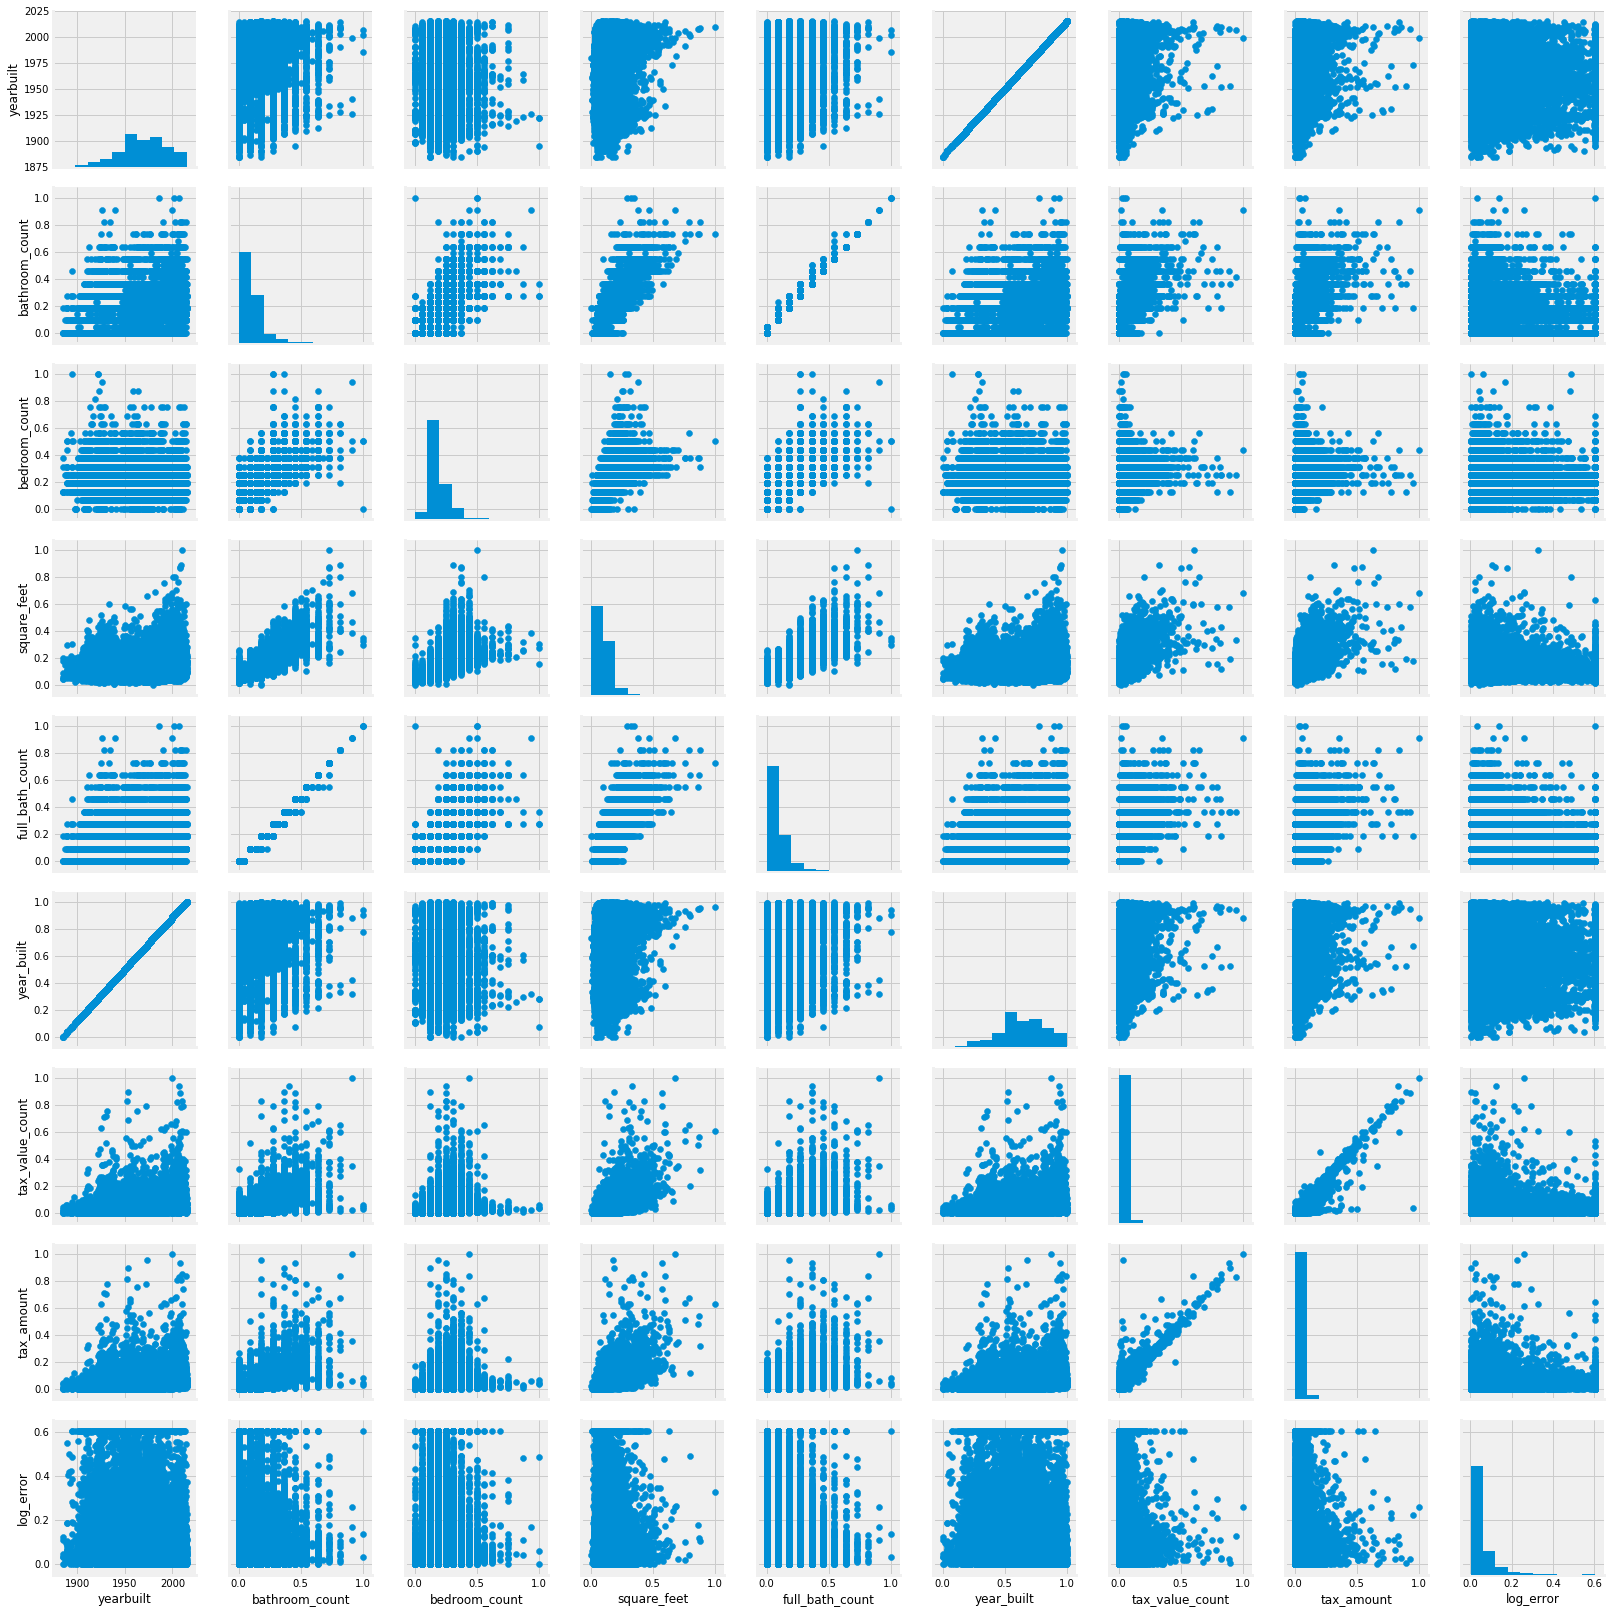

In [29]:
g = sns.PairGrid(std_train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

#### Create a heatmap of the correlation between each variable pair.
- UNnormalized version

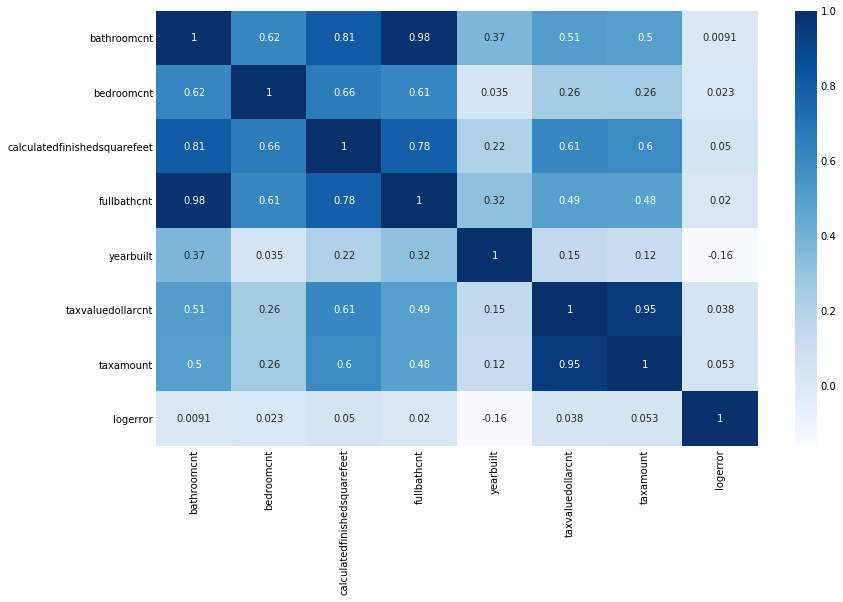

In [30]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(), cmap='Blues', annot=True)

#### Create a heatmap of the correlation between each variable pair.
- normalized version

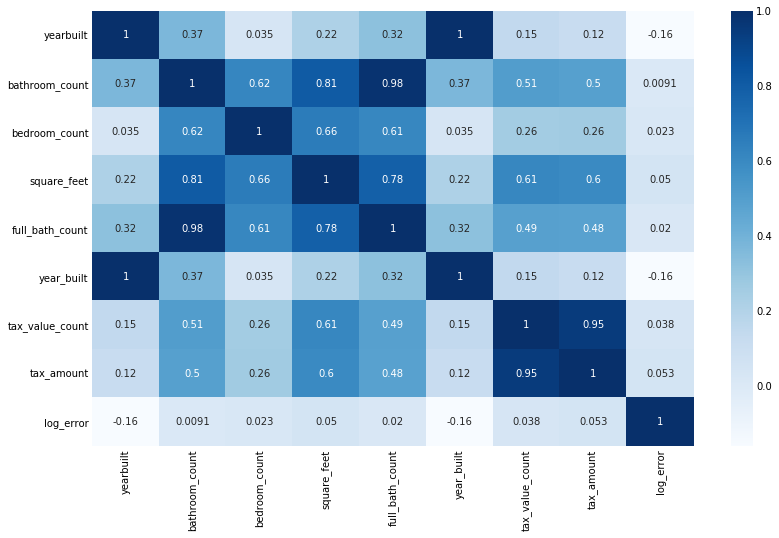

In [31]:
plt.figure(figsize=(12,8))
sns.heatmap(std_train.corr(), cmap='Blues', annot=True)

#### Summarize your conclusions from all of these steps.  

- At this point, only questions #2, #3, and #5 are the ones that can be addressed.

***Log error is nicely distributed and follows a pretty standard or normal distribution. The biggest driver are 1) taxes and square feet. The number of bathrooms and bedrooms do very little in affecting the log error. Meaning, the current Zestimate model already does a very good job in predicting sale prices based on these variables. In conclusion, the Zestimate model can "Zing" better if tax amount, calculated square feet, tax-assessed value, and build year of the property are further investigated and taken into account some more.***

- Both location and HVAC related fields still need to imported and examined.

#### Is the logerror significantly different for homes with 3 bedrooms vs those with 5 or more bedrooms? 
Run a t-test to test this difference.

In [32]:
data_bed_3 = train[train['bedroomcnt'] == 3.0]
data_bed_5 = train[train['bedroomcnt'] >= 5.0]

stat, p = stats.ttest_ind(data_bed_3['logerror'], data_bed_5['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

# if p-value is < 0.05, you can reject the null hypothesis

T-stat: -14.904199659914447
p-value: 4.469207805697199e-50


#### Do the same for another 2 samples that we are interested in comparing.

In [33]:
data_bath_1 = train[train['bathroomcnt'] == 1.0]
data_bath_2 = train[train['bathroomcnt'] >= 2.0]

stat, p = stats.ttest_ind(data_bath_1['logerror'], data_bath_2['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: 19.083488175403506
p-value: 5.571188299610537e-81


In [34]:
data_sq_small = train[train['calculatedfinishedsquarefeet'] < 1300.0]
data_sq_large = train[train['calculatedfinishedsquarefeet'] >= 1300.0]

stat, p = stats.ttest_ind(data_sq_small['logerror'], data_sq_large['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: 3.5719632323554213
p-value: 0.0003545487680126004


## LOCATION-BASED & HVAC FEATURES

In [35]:
# Generate a cohesive dataset based on location
loc_df = pd.merge(train_df, properties_df, on='parcelid', how='inner')
loc_df = loc_df[['logerror',
         'regionidzip']]

In [36]:
# Generate a cohesive dataset based on location
hac_df = pd.merge(train_df, properties_df, on='parcelid', how='inner')
hac_df = hac_df[['logerror',
         'airconditioningtypeid',
         'heatingorsystemtypeid']]

In [37]:
# Check for null values in the columns
print(loc_df.isnull().sum())

# Check number of rows and columns after merging
print(loc_df.shape)

logerror        0
regionidzip    35
dtype: int64
(90275, 2)


In [38]:
# Check for null values in the columns
print(hac_df.isnull().sum())

# Check number of rows and columns after merging
print(hac_df.shape)

logerror                     0
airconditioningtypeid    61494
heatingorsystemtypeid    34195
dtype: int64
(90275, 3)


In [39]:
# Location-based dataset
summarize_df(loc_df)

Summary of Data

Rows & Columns:

(90275, 2)
Variables:

['logerror' 'regionidzip']

Column Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 2 columns):
logerror       90275 non-null float64
regionidzip    90240 non-null float64
dtypes: float64(2)
memory usage: 2.1 MB
None

Numeric Summary Stats:

           logerror    regionidzip
count  90275.000000   90240.000000
mean       0.011457   96586.131184
std        0.161079    3661.339094
min       -4.605000   95982.000000
25%       -0.025300   96193.000000
50%        0.006000   96393.000000
75%        0.039200   96987.000000
max        4.737000  399675.000000

Top 5 Values:

logerror:
0.003    938
0.002    915
0.005    911
0.001    901
0.007    878
Name: logerror, dtype: int64


regionidzip:
97319.0    912
96987.0    902
96974.0    824
97329.0    760
97318.0    726
Name: regionidzip, dtype: int64



Missing Values:

regionidzip    35
dtype: int64

First 5 rows:

   logerror  regionidzi

In [40]:
# HVAC-based dataset
summarize_df(hac_df)

Summary of Data

Rows & Columns:

(90275, 3)
Variables:

['logerror' 'airconditioningtypeid' 'heatingorsystemtypeid']

Column Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 3 columns):
logerror                 90275 non-null float64
airconditioningtypeid    28781 non-null float64
heatingorsystemtypeid    56080 non-null float64
dtypes: float64(3)
memory usage: 2.8 MB
None

Numeric Summary Stats:

           logerror  airconditioningtypeid  heatingorsystemtypeid
count  90275.000000           28781.000000           56080.000000
mean       0.011457               1.816372               3.926979
std        0.161079               2.974168               3.684382
min       -4.605000               1.000000               1.000000
25%       -0.025300               1.000000               2.000000
50%        0.006000               1.000000               2.000000
75%        0.039200               1.000000               7.000000
max        4.7370

In [41]:
# Discard rows where respective column contains null
loc_df = loc_df[loc_df['regionidzip'].notnull()]
loc_df = loc_df.dropna()

# Check for null values
print(loc_df.isnull().sum())
loc_df.sample(10)

logerror       0
regionidzip    0
dtype: int64


,logerror,regionidzip
31476,0.1266,96049.0
77303,-0.0030,96424.0
74134,-0.0325,96364.0
6354,-0.0020,96373.0
808,-0.0545,97041.0
7762,0.1553,96247.0
15117,-0.0672,97048.0
88100,0.0695,96047.0
49045,-0.0790,96193.0
38197,-0.0263,96095.0


In [42]:
# Discard rows where respective column contains null
hac_df = hac_df[hac_df['airconditioningtypeid'].notnull()]
hac_df = hac_df[hac_df['heatingorsystemtypeid'].notnull()]
hac_df = hac_df.dropna()

# Check for null values
print(hac_df.isnull().sum())
hac_df.sample(10)

logerror                 0
airconditioningtypeid    0
heatingorsystemtypeid    0
dtype: int64


,logerror,airconditioningtypeid,heatingorsystemtypeid
55000,0.0535,1.0,2.0
40713,-0.0726,1.0,2.0
66493,0.0060,1.0,2.0
74528,0.0325,1.0,6.0
5562,-0.0834,1.0,2.0
35091,0.0060,1.0,2.0
24855,0.0583,1.0,2.0
61046,0.1187,1.0,2.0
84340,-0.0481,1.0,2.0
83267,0.0760,1.0,2.0


In [43]:
print(loc_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90240 entries, 0 to 90274
Data columns (total 2 columns):
logerror       90240 non-null float64
regionidzip    90240 non-null float64
dtypes: float64(2)
memory usage: 2.1 MB
None


In [44]:
print(hac_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26711 entries, 0 to 90270
Data columns (total 3 columns):
logerror                 26711 non-null float64
airconditioningtypeid    26711 non-null float64
heatingorsystemtypeid    26711 non-null float64
dtypes: float64(3)
memory usage: 834.7 KB
None


In [45]:
# Convert from years to integer
loc_df['regionidzip'] = loc_df['regionidzip'].astype(int)
print(loc_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90240 entries, 0 to 90274
Data columns (total 2 columns):
logerror       90240 non-null float64
regionidzip    90240 non-null int64
dtypes: float64(1), int64(1)
memory usage: 2.1 MB
None


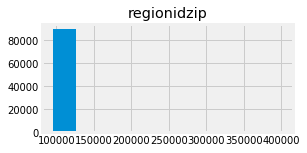

In [46]:
plt.figure(figsize=(4,2))
plt.title('regionidzip')
loc_df.regionidzip.hist()

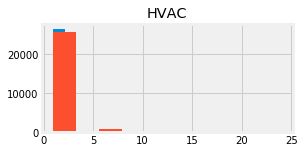

In [47]:
plt.figure(figsize=(4,2))
plt.title('HVAC')
hac_df.airconditioningtypeid.hist()
hac_df.heatingorsystemtypeid.hist()

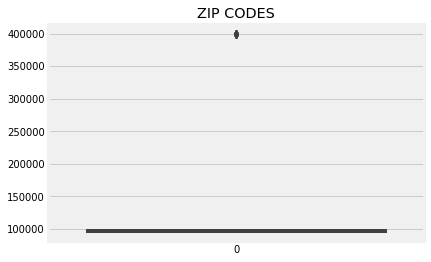

In [48]:
# Box plot
plt.title('ZIP CODES')
sns.boxplot(data=loc_df['regionidzip'])

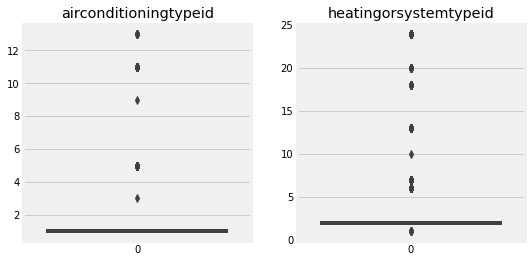

In [49]:
# Box plot
plt.figure(figsize=(8,4))
for i, col in enumerate(['airconditioningtypeid', 'heatingorsystemtypeid'
         ]):
    plot_number = i + 1
    plt.subplot(1,2,plot_number)
    plt.title(col)
    sns.boxplot(data=hac_df[col])

In [50]:
# train_test_split
loc_X = loc_df.drop(['logerror'], axis=1)

print(loc_X.head())

loc_y = loc_df[['logerror']]
print(loc_y.head())

loc_X_train, loc_X_test, loc_y_train, loc_y_test = train_test_split(loc_X, loc_y, train_size=.80, random_state=0)

loc_train = pd.concat([loc_X_train, loc_y_train], axis=1)

print()
print("Train columns:  %s" % list(loc_train.columns))
print("Train dimensions (rows, columns):", loc_train.shape)
print()

loc_test = pd.concat([loc_X_test, loc_y_test], axis=1)

print("Test columns:  %s" % list(loc_test.columns))
print("Test dimensions (rows, columns):", loc_test.shape)
print()

validate_tts(loc_X_train, loc_y_train, loc_X_test, loc_y_test)

loc_X.sample(10)

   regionidzip
0        96370
1        96962
2        96293
3        96222
4        96961
   logerror
0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050

Train columns:  ['regionidzip', 'logerror']
Train dimensions (rows, columns): (72192, 2)

Test columns:  ['regionidzip', 'logerror']
Test dimensions (rows, columns): (18048, 2)

X & y train rows ARE equal
X & y test rows ARE equal
Number of columns in train & test ARE equal
Train Split: 0.80
Test Split: 0.20


,regionidzip
68003,96193
29672,96962
7405,96229
25129,96341
61298,96411
76685,96505
61418,97041
58478,96959
2595,96411
20887,96941


In [51]:
# train_test_split
loc_X = loc_df.drop(['logerror'], axis=1)

print(loc_X.head())

loc_y = loc_df[['logerror']]
print(loc_y.head())

loc_X_train, loc_X_test, loc_y_train, loc_y_test = train_test_split(loc_X, loc_y, train_size=.80, random_state=0)

loc_train = pd.concat([loc_X_train, loc_y_train], axis=1)

print()
print("Train columns:  %s" % list(loc_train.columns))
print("Train dimensions (rows, columns):", loc_train.shape)
print()

loc_test = pd.concat([loc_X_test, loc_y_test], axis=1)

print("Test columns:  %s" % list(loc_test.columns))
print("Test dimensions (rows, columns):", loc_test.shape)
print()

validate_tts(loc_X_train, loc_y_train, loc_X_test, loc_y_test)

loc_X.sample(10)

   regionidzip
0        96370
1        96962
2        96293
3        96222
4        96961
   logerror
0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050

Train columns:  ['regionidzip', 'logerror']
Train dimensions (rows, columns): (72192, 2)

Test columns:  ['regionidzip', 'logerror']
Test dimensions (rows, columns): (18048, 2)

X & y train rows ARE equal
X & y test rows ARE equal
Number of columns in train & test ARE equal
Train Split: 0.80
Test Split: 0.20


,regionidzip
22527,96494
11152,96090
62578,97323
85055,96489
31189,96964
36663,96374
52597,96961
56717,97104
81722,96294
81008,96026


In [52]:
# train_test_split
hac_X = hac_df.drop(['logerror'], axis=1)

print(hac_X.head())

hac_y = hac_df[['logerror']]
print(hac_y.head())

hac_X_train, hac_X_test, hac_y_train, hac_y_test = train_test_split(hac_X, hac_y, train_size=.80, random_state=0)

hac_train = pd.concat([hac_X_train, hac_y_train], axis=1)

print()
print("Train columns:  %s" % list(hac_train.columns))
print("Train dimensions (rows, columns):", hac_train.shape)
print()

hac_test = pd.concat([hac_X_test, hac_y_test], axis=1)

print("Test columns:  %s" % list(hac_test.columns))
print("Test dimensions (rows, columns):", hac_test.shape)
print()

validate_tts(hac_X_train, hac_y_train, hac_X_test, hac_y_test)

hac_X.sample(10)

    airconditioningtypeid  heatingorsystemtypeid
0                     1.0                    2.0
2                     1.0                    2.0
3                     1.0                    2.0
5                     1.0                    2.0
11                    1.0                    2.0
    logerror
0     0.0276
2    -0.0040
3     0.0218
5    -0.2705
11   -0.0161

Train columns:  ['airconditioningtypeid', 'heatingorsystemtypeid', 'logerror']
Train dimensions (rows, columns): (21368, 3)

Test columns:  ['airconditioningtypeid', 'heatingorsystemtypeid', 'logerror']
Test dimensions (rows, columns): (5343, 3)

X & y train rows ARE equal
X & y test rows ARE equal
Number of columns in train & test ARE equal
Train Split: 0.80
Test Split: 0.20


,airconditioningtypeid,heatingorsystemtypeid
55105,1.0,2.0
22449,1.0,6.0
30702,1.0,2.0
85182,1.0,2.0
21317,1.0,2.0
14887,1.0,2.0
35798,1.0,2.0
87905,1.0,2.0
78147,1.0,2.0
7010,1.0,2.0


/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


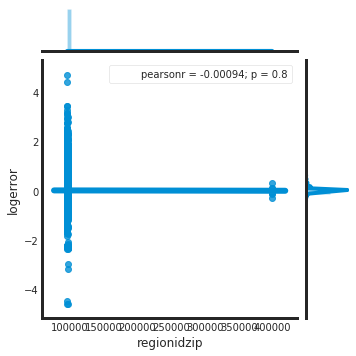

In [53]:
with sns.axes_style('white'):
    j = sns.jointplot('regionidzip', "logerror", data=loc_train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


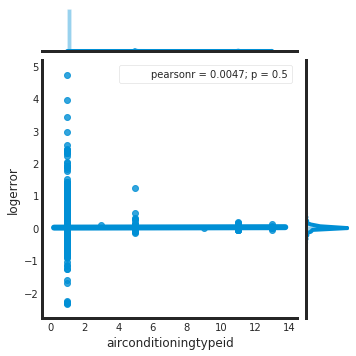

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


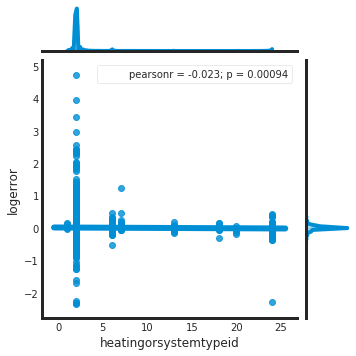

In [54]:
with sns.axes_style('white'):
    j = sns.jointplot('airconditioningtypeid', "logerror", data=hac_train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('heatingorsystemtypeid', "logerror", data=hac_train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

### Data Modeling

#### Use statsmodels ordinary least squares to assess the importance of each feature with respect to the target

In [55]:
ols_model = sm.OLS(y_train, X_train)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     4746.
Date:                Tue, 26 Mar 2019   Prob (F-statistic):               0.00
Time:                        09:24:01   Log-Likelihood:                 68637.
No. Observations:               71192   AIC:                        -1.373e+05
Df Residuals:                   71185   BIC:                        -1.372e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
bathroomcnt                     -0.0445      0.002    -21.005      0.000      -0.049      -0.040
bedroomcnt                      -0.0001      0.000     -0.321      0.748      -0.001       0.001
calculatedfinishedsquarefeet  1.205e-05   7.72e-07     15.617      0.000    1.05e-05    1.36e-05
fullbathcnt                      0.0364      0.002     17.752      0.000       0.032       0.040
yearbuilt                     3.031e-05   5.54e-07     54.759      0.000    2.92e-05    3.14e-05
taxvaluedollarcnt            -2.067e-08   2.13e-09     -9.708      0.000   -2.48e-08   -1.65e-08
taxamount                     2.041e-06   1.71e-07     11.966      0.000    1.71e-06    2.37e-06
==============================================================================
Omnibus:                    52099.983   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           791008.785
Skew:                           3.500   Prob(JB):                         0.00
Kurtosis:                      17.753   Cond. No.                     5.87e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.87e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
loc_ols_model = sm.OLS(loc_y_train, loc_X_train)
loc_fit = loc_ols_model.fit()
loc_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     361.0
Date:                Tue, 26 Mar 2019   Prob (F-statistic):           2.64e-80
Time:                        09:24:01   Log-Likelihood:                 29403.
No. Observations:               72192   AIC:                        -5.880e+04
Df Residuals:                   72191   BIC:                        -5.879e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
regionidzip  1.178e-07    6.2e-09     19.001      0.000    1.06e-07     1.3e-07
==============================================================================
Omnibus:                    47154.652   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         49725277.875
Skew:                           1.706   Prob(JB):                         0.00
Kurtosis:                     131.528   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
hac_ols_model = sm.OLS(hac_y_train, hac_X_train)
hac_fit = hac_ols_model.fit()
hac_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     79.03
Date:                Tue, 26 Mar 2019   Prob (F-statistic):           6.39e-35
Time:                        09:24:01   Log-Likelihood:                 11516.
No. Observations:               21368   AIC:                        -2.303e+04
Df Residuals:                   21366   BIC:                        -2.301e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
airconditioningtypeid     0.0104      0.001     10.361      0.000       0.008       0.012
heatingorsystemtypeid    -0.0004      0.000     -1.074      0.283      -0.001       0.000
==============================================================================
Omnibus:                    28002.012   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         31606122.314
Skew:                           6.699   Prob(JB):                         0.00
Kurtosis:                     190.935   Cond. No.                         4.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Plan for the model: combine variables together and see what combination yields the best results.

#### Train & Test Model

In [58]:
# Create linear regression objects
lm1 = LinearRegression()
print(lm1)

lm1.fit(X_train[['calculatedfinishedsquarefeet']], y_train)
print(lm1)

lm1_y_intercept = lm1.intercept_
print(lm1_y_intercept)

lm1_coefficients = lm1.coef_
print(lm1_coefficients)

print()
print('Univariate - log error = b + m1 * square feet')
print('    y-intercept  (b): %.2f' % lm1_y_intercept)
print('    coefficient (m1): %.2f' % lm1_coefficients[0][0])

y_pred_lm1 = lm1.predict(X_train[['calculatedfinishedsquarefeet']])

mse_lm1 = mean_squared_error(y_train, y_pred_lm1)
print("lm1\n  mse: {:.3}".format(mse_lm1)) 

r2_lm1 = r2_score(y_train, y_pred_lm1)

print('  {:.2%} of the variance in the log error can be explained by the number of square feet.'.format(r2_lm1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.05343332]
[[5.05228772e-06]]

Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.05
    coefficient (m1): 0.00
lm1
  mse: 0.00858
  0.25% of the variance in the log error can be explained by the number of square feet.


In [59]:
# Create linear regression objects
lm2 = LinearRegression()
print(lm2)

lm2.fit(X_train[['bathroomcnt', 'fullbathcnt']], y_train)
print(lm2)

lm2_y_intercept = lm2.intercept_
print(lm2_y_intercept)

lm2_coefficients = lm2.coef_
print(lm2_coefficients)

print()
print('Multivariate - log error = b + m1 * bathroom count + m2 * full bath count')
print('    y-intercept  (b): %.2f' % lm2_y_intercept)
print('    coefficient (m1): %.2f' % lm2_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm2_coefficients[0][1])

y_pred_lm2 = lm2.predict(X_train[['bathroomcnt', 'fullbathcnt']])

mse_lm2 = mean_squared_error(y_train, y_pred_lm2)
print("lm2\n  mse: {:.3}".format(mse_lm2)) 

r2_lm2 = r2_score(y_train, y_pred_lm2)

print('  {:.2%} of the variance in the log error can be explained by the number of bathrooms.'.format(r2_lm2))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.0603551]
[[-0.03224535  0.03411209]]

Multivariate - log error = b + m1 * bathroom count + m2 * full bath count
    y-intercept  (b): 0.06
    coefficient (m1): -0.03
    coefficient (m2): 0.03
lm2
  mse: 0.00856
  0.40% of the variance in the log error can be explained by the number of bathrooms.


In [60]:
# Create linear regression objects
lm3 = LinearRegression()
print(lm3)

lm3.fit(X_train[['bedroomcnt']], y_train)
print(lm3)

lm3_y_intercept = lm3.intercept_
print(lm3_y_intercept)

lm3_coefficients = lm3.coef_
print(lm3_coefficients)

print()
print('Multivariate - log error = b + m1 * bedroom count')
print('    y-intercept  (b): %.2f' % lm3_y_intercept)
print('    coefficient (m1): %.2f' % lm3_coefficients[0][0])

y_pred_lm3 = lm3.predict(X_train[['bedroomcnt']])

mse_lm3 = mean_squared_error(y_train, y_pred_lm3)
print("lm3\n  mse: {:.3}".format(mse_lm3)) 

r2_lm3 = r2_score(y_train, y_pred_lm3)

print('  {:.2%} of the variance in the log error can be explained by the number of bedrooms.'.format(r2_lm3))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.0565702]
[[0.00188704]]

Multivariate - log error = b + m1 * bedroom count
    y-intercept  (b): 0.06
    coefficient (m1): 0.00
lm3
  mse: 0.00859
  0.05% of the variance in the log error can be explained by the number of bedrooms.


In [61]:
# Create linear regression objects
lm4 = LinearRegression()
print(lm4)

lm4.fit(X_train[['calculatedfinishedsquarefeet', 'bathroomcnt', 'fullbathcnt', 'bedroomcnt', 'taxvaluedollarcnt', 'taxamount']], y_train)
print(lm4)

lm4_y_intercept = lm4.intercept_
print(lm4_y_intercept)

lm4_coefficients = lm4.coef_
print(lm4_coefficients)

print()
print('Multivariate:')
print('    y-intercept  (b): %.2f' % lm4_y_intercept)
print('    coefficient (m1): %.2f' % lm4_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm4_coefficients[0][1])
print('    coefficient (m1): %.2f' % lm4_coefficients[0][2])
print('    coefficient (m2): %.2f' % lm4_coefficients[0][3])
print('    coefficient (m2): %.2f' % lm4_coefficients[0][4])
print('    coefficient (m2): %.2f' % lm4_coefficients[0][5])

y_pred_lm4 = lm4.predict(X_train[['calculatedfinishedsquarefeet', 'bathroomcnt', 'fullbathcnt', 'bedroomcnt', 'taxvaluedollarcnt', 'taxamount']])

mse_lm4 = mean_squared_error(y_train, y_pred_lm4)
print("lm4\n  mse: {:.3}".format(mse_lm4)) 

r2_lm4 = r2_score(y_train, y_pred_lm4)

print('  {:.2%} of the variance in the log error can be explained by the number of bathrooms.'.format(r2_lm4))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.06086611]
[[ 1.21828806e-05 -4.34674090e-02  3.55780204e-02 -6.77159732e-04
  -2.03815311e-08  2.00676322e-06]]

Multivariate:
    y-intercept  (b): 0.06
    coefficient (m1): 0.00
    coefficient (m2): -0.04
    coefficient (m1): 0.04
    coefficient (m2): -0.00
    coefficient (m2): -0.00
    coefficient (m2): 0.00
lm4
  mse: 0.00849
  1.21% of the variance in the log error can be explained by the number of bathrooms.


In [62]:
# Create linear regression objects
lm5 = LinearRegression()
print(lm5)

lm5.fit(X_train[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount']], y_train)
print(lm5)

lm5_y_intercept = lm5.intercept_
print(lm5_y_intercept)

lm5_coefficients = lm5.coef_
print(lm5_coefficients)

print()
print('Multivariate:')
print('    y-intercept  (b): %.2f' % lm5_y_intercept)
print('    coefficient (m1): %.2f' % lm5_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm5_coefficients[0][1])
print('    coefficient (m1): %.2f' % lm5_coefficients[0][2])

y_pred_lm5 = lm5.predict(X_train[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount']])

mse_lm5 = mean_squared_error(y_train, y_pred_lm5)
print("lm5\n  mse: {:.3}".format(mse_lm5)) 

r2_lm5 = r2_score(y_train, y_pred_lm5)

print('  {:.2%} of the variance in the log error can be explained by tax and square feet.'.format(r2_lm5))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.05298137]
[[ 3.80536996e-06 -2.43677182e-08  2.31040195e-06]]

Multivariate:
    y-intercept  (b): 0.05
    coefficient (m1): 0.00
    coefficient (m2): -0.00
    coefficient (m1): 0.00
lm5
  mse: 0.00855
  0.51% of the variance in the log error can be explained by tax and square feet.


In [63]:
# Create linear regression objects
lm6 = LinearRegression()
print(lm6)

lm6.fit(X_train[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount', 'yearbuilt']], y_train)
print(lm6)

lm6_y_intercept = lm6.intercept_
print(lm6_y_intercept)

lm6_coefficients = lm6.coef_
print(lm6_coefficients)

print()
print('Multivariate:')
print('    y-intercept  (b): %.2f' % lm6_y_intercept)
print('    coefficient (m1): %.2f' % lm6_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm6_coefficients[0][1])
print('    coefficient (m1): %.2f' % lm6_coefficients[0][2])
print('    coefficient (m1): %.2f' % lm6_coefficients[0][3])

y_pred_lm6 = lm6.predict(X_train[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount', 'yearbuilt']])

mse_lm6 = mean_squared_error(y_train, y_pred_lm6)
print("lm6\n  mse: {:.3}".format(mse_lm6)) 

r2_lm6 = r2_score(y_train, y_pred_lm6)

print('  {:.2%} of the variance in the log error can be explained by tax, square feet, and year built.'.format(r2_lm6))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[1.40339011]
[[ 7.57043555e-06 -1.67797787e-08  1.71039269e-06 -6.89318921e-04]]

Multivariate:
    y-intercept  (b): 1.40
    coefficient (m1): 0.00
    coefficient (m2): -0.00
    coefficient (m1): 0.00
    coefficient (m1): -0.00
lm6
  mse: 0.0083
  3.48% of the variance in the log error can be explained by tax, square feet, and year built.


In [64]:
# Create linear regression objects
lm7 = LinearRegression()
print(lm7)

lm7.fit(loc_X_train[['regionidzip']], loc_y_train)
print(lm7)

lm7_y_intercept = lm7.intercept_
print(lm7_y_intercept)

lm7_coefficients = lm7.coef_
print(lm7_coefficients)

print()
print('Univariate - log error = b + m1 * zip code')
print('    y-intercept  (b): %.2f' % lm7_y_intercept)
print('    coefficient (m1): %.2f' % lm7_coefficients[0][0])

y_pred_lm7 = lm7.predict(loc_X_train[['regionidzip']])

mse_lm7 = mean_squared_error(loc_y_train, y_pred_lm7)
print("lm7\n  mse: {:.3}".format(mse_lm7)) 

r2_lm7 = r2_score(loc_y_train, y_pred_lm7)

print('  {:.2%} of the variance in the log error can be explained by zip code.'.format(r2_lm7))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.01545069]
[[-4.19339526e-08]]

Univariate - log error = b + m1 * zip code
    y-intercept  (b): 0.02
    coefficient (m1): -0.00
lm7
  mse: 0.0259
  0.00% of the variance in the log error can be explained by zip code.


In [65]:
# Create linear regression objects
lm8 = LinearRegression()
print(lm8)

lm8.fit(hac_X_train[['airconditioningtypeid', 'heatingorsystemtypeid']], hac_y_train)
print(lm8)

lm8_y_intercept = lm8.intercept_
print(lm8_y_intercept)

lm8_coefficients = lm8.coef_
print(lm8_coefficients)

print()
print('Multivariate:')
print('    y-intercept  (b): %.2f' % lm8_y_intercept)
print('    coefficient (m1): %.2f' % lm8_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm8_coefficients[0][1])

y_pred_lm8 = lm8.predict(hac_X_train[['airconditioningtypeid', 'heatingorsystemtypeid']])

mse_lm8 = mean_squared_error(hac_y_train, y_pred_lm8)
print("lm8\n  mse: {:.3}".format(mse_lm8)) 

r2_lm8 = r2_score(hac_y_train, y_pred_lm8)

print('  {:.2%} of the variance in the log error can be explained by hvac systems.'.format(r2_lm8))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.01485494]
[[ 0.00184358 -0.00124833]]

Multivariate:
    y-intercept  (b): 0.01
    coefficient (m1): 0.00
    coefficient (m2): -0.00
lm8
  mse: 0.0199
  0.06% of the variance in the log error can be explained by hvac systems.


#### Model #6 yields the best results of all training models.

#### Fit, predict (in-sample) & evaluate multiple linear regression models to find the best one.

Text(0.5, 1.0, 'Predicted vs Actual Log Error')

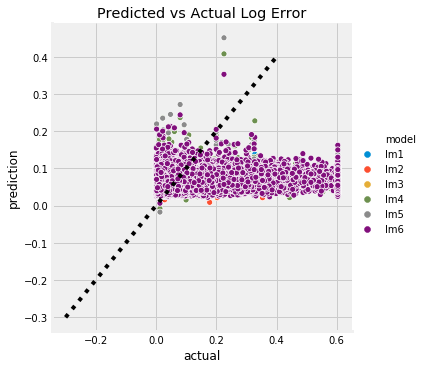

In [66]:
# We want just a single array of predictions. We can use
# the .ravel method to achieve this.

pd.DataFrame({'actual': y_train.logerror,
              'lm1': y_pred_lm1.ravel(),
              'lm2': y_pred_lm2.ravel(),
              'lm3': y_pred_lm3.ravel(),
              'lm4': y_pred_lm4.ravel(),
              'lm5': y_pred_lm5.ravel(),
              'lm6': y_pred_lm6.ravel()
             })\
    .melt(id_vars=['actual'], var_name='model', value_name='prediction')\
    .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')

plt.plot([-.3, .4], [-.3, .4], c='black', ls=':')
plt.title('Predicted vs Actual Log Error')

Text(0.5, 1.0, 'Predicted vs Actual Log Error')

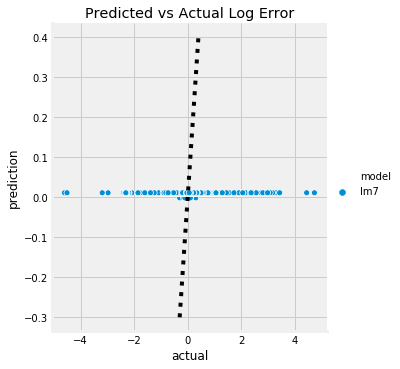

In [67]:
pd.DataFrame({'actual': loc_y_train.logerror,
              'lm7': y_pred_lm7.ravel()
             })\
    .melt(id_vars=['actual'], var_name='model', value_name='prediction')\
    .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')

plt.plot([-.3, .4], [-.3, .4], c='black', ls=':')
plt.title('Predicted vs Actual Log Error')

Text(0.5, 1.0, 'Predicted vs Actual Log Error')

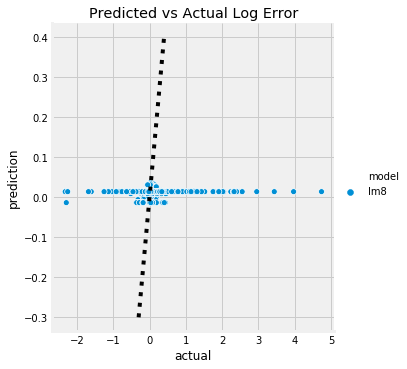

In [68]:
pd.DataFrame({'actual': hac_y_train.logerror,
              'lm8': y_pred_lm8.ravel()
             })\
    .melt(id_vars=['actual'], var_name='model', value_name='prediction')\
    .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')

plt.plot([-.3, .4], [-.3, .4], c='black', ls=':')
plt.title('Predicted vs Actual Log Error')

#### Predict log errors using testing data

In [69]:
# Make predictions using the testing set
y_pred_lm6 = lm6.predict(X_test[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount', 'yearbuilt']])

#### Evaluate performance

In [70]:
mse = mean_squared_error(y_test, y_pred_lm6)

print("Mean squared error: %.2f" % mse)

Mean squared error: 0.01


In [71]:
r2 = r2_score(y_test, y_pred_lm6)

print('{:.2%} of the variance in log errors can be explained by calculatedfinishedsquarefeet, bathroomcnt, fullbathcnt, bedroomcnt, taxvaluedollarcnt, taxamount.'
      .format(r2))

4.02% of the variance in log errors can be explained by calculatedfinishedsquarefeet, bathroomcnt, fullbathcnt, bedroomcnt, taxvaluedollarcnt, taxamount.


Text(0, 0.5, 'Residuals')

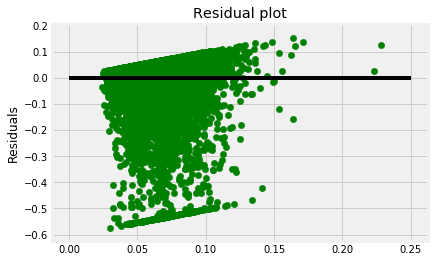

In [72]:
plt.scatter(y_pred_lm6, y_pred_lm6 - y_test, c='g', s=40)
plt.hlines(y=0, xmin=0, xmax=.25)
plt.title("Residual plot")
plt.ylabel('Residuals')

### Model Performance

The plot of residuals shows a pretty cohesive pattern of concentration that leads me to believe that more work is needed for real insight to be gained. The model above would do poorly in a production environment.